In [40]:
import pandas as pd
import re
import nltk
import itertools
import contractions
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalAveragePooling1D
import joblib

In [7]:
# Load your dataset
df = pd.read_csv("C:\\Users\\abhve\\Downloads\\Analysisfile.csv")

C:\Users\abhve\AppData\Local\Temp\ipykernel_5184\1670251161.py:2: DtypeWarning: Columns (2,3,8,11,12,13,14,15,16,18,20,21,22,23,24,25,28,29,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:\\Users\\abhve\\Downloads\\Analysisfile.csv")


In [8]:
column = 'OR_user_description'
label_column = 'Annotate'

In [9]:
# Handle missing values
df[column] = df[column].fillna('')  # Replace NaN with an empty string


In [10]:
df['Annotate'] = df['Annotate'].apply(lambda x: str(x))
df['Annotate'] = df['Annotate'].str.replace(' ', '')
df['Annotate'] = df['Annotate'].apply(lambda x: x.lower())
unique_values = df['Annotate'].unique()
print(unique_values)

['bjps' 'ir' 'media' 'nu' 'aaps' 'incs' 'inc' 'bjp' 'antibjp' 'aimim'
 'tmc' 'aiadmks' 'ysrcps' 'ammk' 'ncp' 'nan' 'mnss']


In [11]:
# Convert all values to strings
df[column] = df[column].apply(lambda x: str(x))

In [12]:
# Text Preprocessing
df[column] = df[column].apply(lambda x: x.lower())
df[column] = df[column].apply(lambda x: contractions.fix(x))
df[column] = df[column].apply(lambda x: ''.join(''.join(c)[:2] for _, c in itertools.groupby(x)))
punctuations_regex = "!#%&\'()\*+,-/:;<=>?@[\\]^_`{|}~.1234567890"
df[column] = df[column].apply(lambda x: re.sub('[%s]' % re.escape(punctuations_regex), ' ', x))
df[column] = df[column].apply(lambda x: ' '.join(nltk.word_tokenize(x)))

In [13]:
# Load GloVe word vectors
glove_file_path = 'glove.6B.100d.txt'  # Change the path based on your downloaded file
word_embeddings = {}
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs

In [14]:
# Function to get the vector representation of a sentence
def get_sentence_vector(sentence):
    if pd.isna(sentence):  # Check for NaN values
        return np.zeros(100)
    
    vectors = [word_embeddings.get(word, np.zeros(100)) for word in sentence.split()]
    vectors = [vec for vec in vectors if vec.shape == (100,)]  # Filter out zero vectors
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)  # Return zero vector if no valid vectors are found

In [15]:
# Apply GloVe vectors to each row
df['glove_vector'] = df[column].apply(get_sentence_vector)

In [16]:
# Create features from GloVe vectors
features = np.vstack(df['glove_vector'].to_numpy())

In [30]:
from keras.utils import to_categorical

In [17]:
# Encode Labels
label_encoder = LabelEncoder()
df[label_column] = label_encoder.fit_transform(df[label_column])

In [18]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, df[label_column], test_size=0.2, random_state=42)

In [26]:
# Tokenization and Padding for LSTM
max_words = 500  # You may need to adjust this based on your dataset
max_sequence_length = 100  # Set the maximum sequence length to match GloVe vectors
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df[column])
sequences = tokenizer.texts_to_sequences(df[column])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

In [27]:
# LSTM Model
embedding_dim = 300  # You may need to adjust this based on your dataset
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length, trainable=False),
    LSTM(units=100, return_sequences=True),
    GlobalAveragePooling1D(),
    Dense(units=len(label_encoder.classes_), activation='softmax')
])


In [31]:
# Convert labels to one-hot encoding
y_one_hot = to_categorical(df[label_column])


In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(padded_sequences, y_one_hot, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
3126/3126 [==============================] - 88s 28ms/step - loss: 1.2651 - accuracy: 0.6177 - val_loss: 7.3061 - val_accuracy: 0.0000e+00
Epoch 2/10
3126/3126 [==============================] - 88s 28ms/step - loss: 1.0105 - accuracy: 0.6892 - val_loss: 12.2884 - val_accuracy: 0.0000e+00
Epoch 3/10
3126/3126 [==============================] - 87s 28ms/step - loss: 0.7132 - accuracy: 0.7900 - val_loss: 8.6727 - val_accuracy: 0.0000e+00
Epoch 4/10
3126/3126 [==============================] - 95s 30ms/step - loss: 0.4262 - accuracy: 0.8831 - val_loss: 7.2870 - val_accuracy: 0.0000e+00
Epoch 5/10
3126/3126 [==============================] - 94s 30ms/step - loss: 0.2912 - accuracy: 0.9239 - val_loss: 8.1591 - val_accuracy: 0.0000e+00
Epoch 6/10
3126/3126 [==============================] - 92s 29ms/step - loss: 0.1690 - accuracy: 0.9576 - val_loss: 7.2289 - val_accuracy: 0.0000e+00
Epoch 7/10
3126/3126 [==============================] - 89s 28ms/step - loss: 0.0967 - accuracy: 0.

In [46]:
model.save('lstm.keras')


In [33]:
# Tokenization and Padding for LSTM
sequences_test = tokenizer.texts_to_sequences(df[column])
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_sequence_length, padding='post', truncating='post')


In [34]:
# Model Evaluation
y_pred_probs = model.predict(padded_sequences_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = df[label_column]


3907/3907 [==============================] - 44s 11ms/step


In [42]:
print("Accuracy: {:.2f}%".format(accuracy_score(df.Annotate, y_pred)*100))

Accuracy: 79.04%


In [35]:
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9992    0.9864    0.9927      1246
           1     0.9872    0.9167    0.9506        84
           2     0.7460    1.0000    0.8545        94
           3     1.0000    0.9369    0.9674       333
           4     0.9984    0.9944    0.9964      4428
           5     0.9524    0.9896    0.9707      5299
           6     0.9908    0.9770    0.9838     10115
           7     0.9782    0.9984    0.9882      1889
           8     0.9984    0.9081    0.9511      3429
           9     0.6842    0.9952    0.8109     55555
          10     0.9928    0.9883    0.9905     10258
          11     1.0000    0.6190    0.7647        21
          12     0.0000    0.0000    0.0000     25040
          13     1.0000    1.0000    1.0000       138
          14     0.9764    0.9886    0.9825      6771
          15     1.0000    0.9912    0.9956       227
          16     1.0000    0.8791    0.9357        91

    accuracy              

C:\Users\abhve\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abhve\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abhve\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [ ]:
#ignore below

In [20]:
## Testing

In [47]:
from tensorflow.keras.models import load_model


In [48]:

new_df = pd.read_csv("C:\\Users\\abhve\\Downloads\\tested.csv")

In [49]:
new_column = 'OR_user_description'

In [50]:
new_df[new_column] = new_df[new_column].fillna('')  # Replace NaN with an empty string

In [51]:
# Convert all values to strings
new_df[new_column] = new_df[new_column].apply(lambda x: str(x))

In [52]:
# Text Preprocessing
new_df[new_column] = new_df[new_column].apply(lambda x: x.lower())
new_df[new_column] = new_df[new_column].apply(lambda x: contractions.fix(x))
punctuations_regex = "!#%&\'()\*+,-/:;<=>?@[\\]^_`{|}~.1234567890"
new_df[new_column] = new_df[new_column].apply(lambda x: re.sub('[%s]' % re.escape(punctuations_regex), ' ', x))
new_df[new_column] = new_df[new_column].apply(lambda x: ' '.join(nltk.word_tokenize(x)))


In [53]:
# Apply GloVe vectors to each row
new_df['glove_vector'] = new_df[new_column].apply(get_sentence_vector)

In [54]:
# Create features from GloVe vectors
new_features = np.vstack(new_df['glove_vector'].to_numpy())

In [55]:
# Tokenization and Padding for LSTM
sequences_new = tokenizer.texts_to_sequences(new_df[new_column])
padded_sequences_new = pad_sequences(sequences_new, maxlen=max_sequence_length, padding='post', truncating='post')


In [56]:
# Load the pre-trained LSTM model
model = load_model('lstm.keras')

In [ ]:
# Model Prediction
new_pred_probs = model.predict(padded_sequences_new)
new_pred = np.argmax(new_pred_probs, axis=1)

2876/6026 [=============>................] - ETA: 37s

In [ ]:
# Decode the predicted labels using the label encoder
new_pred_labels = label_encoder.inverse_transform(new_pred)

In [ ]:
# Add the predicted labels to the new dataset
new_df['predicted_labels'] = new_pred_labels

In [60]:
# Save the new dataset with predicted labels
new_df.to_csv("tested_lstm.csv", index=False)

In [ ]:
##restart here

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


['aaps' 'aiadmks' 'aimim' 'ammk' 'antibjp' 'bjp' 'bjps' 'inc' 'incs' 'ir'
 'media' 'mnss' 'nan' 'ncp' 'nu' 'tmc' 'ysrcps']


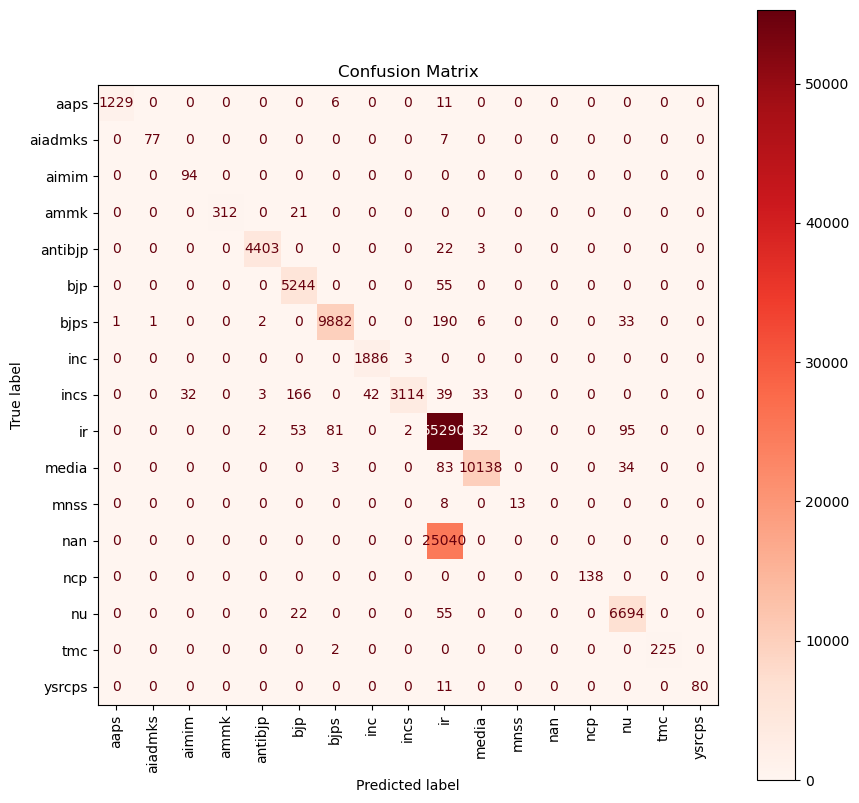

In [45]:
conf_matrix = confusion_matrix(y_true, y_pred)
classes = label_encoder.classes_
print(classes)


# Display Confusion Matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
fig, ax = plt.subplots(figsize=(10, 10))
cm_display.plot(cmap='Reds', values_format='d', ax=ax)

# Rotate x-axis labels by 180 degrees
ax.set_xticklabels(classes, rotation=90)

plt.title('Confusion Matrix')
plt.show()